# NLP - Spam or Ham filter

## By: Anita Maskara

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#preprocessing">Text Preprocessing</a></li>
<li><a href="#vectorization">Vectorization</a></li>   
<li><a href="#tfidf">TF-IDF</a></li> 
<li><a href="#training a model">Training a model</a></li>
<li><a href="#creating a pipeline">Creating a pipeline</a></li> 
<li><a href="#model evaluation">Model Evaluation</a></li> 
</ul>

<a id='intro'></a>
## Introduction



We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)! This dataset is already located in the folder for this section.

The SMS Spam Collection is a public set of SMS labeled messages that have been collected for mobile phone spam research.

The file contains a collection of more than 5000 SMS phone messages

<a id='wrangling'></a>
## Data Wrangling

### Setup

In [55]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
sns.set_style('whitegrid')
sns.set_context("talk")

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [56]:
import nltk

In [57]:
# downloading stopwords

# nltk.download_shell()

### Gathering data

Let's go ahead and use rstrip() plus a list comprehension to get a list of all the lines of text messages:

In [58]:
messages = [line.rstrip() for line in open('C:\\Users\\aabha.DESKTOP-HG6KK17\\Downloads\\Py-DS-ML-Bootcamp-master\\Refactored_Py_DS_ML_Bootcamp-master\\20-Natural-Language-Processing\\smsspamcollection\\smsspamcollection')]

In [59]:
# lets look at the first message
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

We see that the file is tab separated file because we can notice \t after ham

In [60]:
# lets see the first 10 messages
for mess_no, text in enumerate(messages[0:10]):
    print(mess_no, text)
    print('/n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
/n
1 ham	Ok lar... Joking wif u oni...
/n
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
/n
3 ham	U dun say so early hor... U c already then say...
/n
4 ham	Nah I don't think he goes to usf, he lives around here though
/n
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
/n
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
/n
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
/n
8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. C

**We see that the first word is the label - spam or ham; the second column is the text of the message**

**Let's import the messages into a df containing two columns - label and text**

In [61]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('C:\\Users\\aabha.DESKTOP-HG6KK17\\Downloads\\Py-DS-ML-Bootcamp-master\\Refactored_Py_DS_ML_Bootcamp-master\\20-Natural-Language-Processing\\smsspamcollection\\smsspamcollection', 
                 sep = '\t', names = ['label', 'text'])

In [62]:
# high-level overview of data shape and composition

# The number of rows and columns in df
df.shape

(5572, 2)

In [63]:
# checking the datatypes of the columns
dtype_df = {}
values = []
dtypes = []

for column in df.columns:
    value = df[column].head(1).values[0]
    dtype = df[column].head(1).dtype
    values.append(value)
    dtypes.append(dtype)

dtype_df = pd.DataFrame({'column_name':df.columns, 
                        'value':values,
                        'dtype':dtypes})

dtype_df

,column_name,value,dtype
0,label,ham,object
1,text,"Go until jurong point, crazy.. Available only ...",object


In [64]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Assessing data

In [65]:
# generating summary statistics
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


**There are two unique labels. 5169 out of 5572 messages are unique, which means that there are repeated messages**

In [66]:
df[df['label']=="ham"].count()/df.shape[0]

label    0.865937
text     0.865937
dtype: float64

**out of 5572 messages, 86% messages are labeled as ham**

In [67]:
df.duplicated().sum()

403

**403 messages are duplicated, eg. "Sorry, I will call later", "Yes", "Ok", etc**

<a id='eda'></a>
## Exploratory Data Analysis

<a id="new_variables"></a>
### Feature Engineering

**Define**

Get the length of the text messages

**Code**

In [68]:
df['length']=df['text'].apply(len)

**Test**

In [69]:
df.head()

,label,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [70]:
df['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

### Univariate Exploration of Data

Variable: length

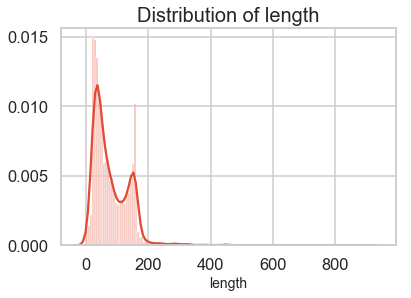

In [71]:
# creating histogram of length variable
sns.distplot(df['length'], bins=150)
plt.title('Distribution of length', fontsize=20)
plt.xlabel('length', fontsize=14);

**Interpretation:** We see bimodal behavior. There are two peaks - one at the lower end and one around 200.

In [72]:
df['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

**910 looks like an outlier. Let's look into this**

In [73]:
df[df['length']==910]['text'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

## Bivariate Exploration of data

Variable: length and label

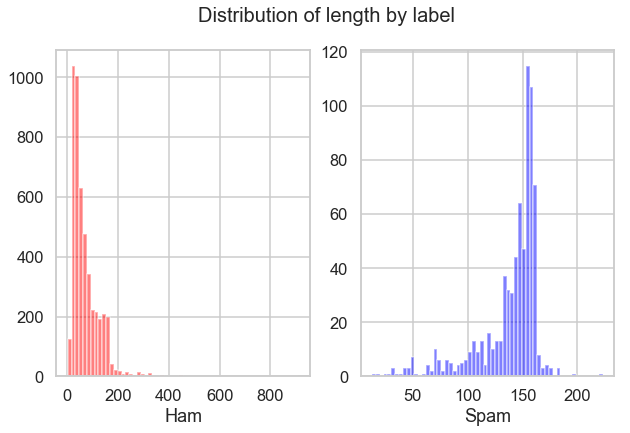

In [74]:
plt.figure(figsize=(10,6))
plt.suptitle('Distribution of length by label', fontsize=20)

plt.subplot(1,2,1)
df[df['label']=="ham"]['length'].hist(bins=60, alpha = 0.5, color='red')
plt.xlabel("Ham")
plt.subplot(1,2,2)
df[df['label']=="spam"]['length'].hist(bins=60, alpha =0.5, color='blue')
plt.xlabel("Spam");


In [75]:
df.groupby('label')['length'].mean()

label
ham      71.482487
spam    138.670683
Name: length, dtype: float64

**Interpretation:** We discover that spam messages tend to have more characters as compared to ham messages. Ham messages have on average 70 characters. Spam messages on average have 150 characters. 

<a id='text preprocessing'></a>
# Text Preprocessing

Step 1: Remove punctuation<br>
Step 2: Split the text into its individual words and return a list<br>
Step 3:Remove common words or stopwords like 'the', 'and', 'a', 'if'

In [76]:
import string

**Lets import stopwords from nltk**

In [77]:
from nltk.corpus import stopwords

In [78]:
# these are the words that are included in stopwords in English
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

These are common words that do not tell you anything more about any distinguishing features

**Trying out how to remove punctuation on a sample message**

In [79]:
message = 'Sample message! Notice: it has punctuation.'

In [80]:
no_punctuation = [c for c in message if c not in string.punctuation]

In [81]:
no_punctuation

['S',
 'a',
 'm',
 'p',
 'l',
 'e',
 ' ',
 'm',
 'e',
 's',
 's',
 'a',
 'g',
 'e',
 ' ',
 'N',
 'o',
 't',
 'i',
 'c',
 'e',
 ' ',
 'i',
 't',
 ' ',
 'h',
 'a',
 's',
 ' ',
 'p',
 'u',
 'n',
 'c',
 't',
 'u',
 'a',
 't',
 'i',
 'o',
 'n']

We see that the !  :  .   all have been removed and replaced with a blank

In [82]:
# Now with join() we can rebuild the words 
no_punctuation = "".join(no_punctuation)

no_punctuation

'Sample message Notice it has punctuation'

Now we are going to remove stopwords from no_punctuation

In [83]:
clean_message = [word for word in no_punctuation.split() if word.lower() not in stopwords.words('english')]

In [84]:
clean_message

['Sample', 'message', 'Notice', 'punctuation']

**So this is how we are going to clean the text in our df - we removed the punctuation and the stopwords**

### Tokenizing the messages

- Tokenizing means converting a normal text string into a list of words aka tokens 

In [85]:
def text_cleaning_process(text):
    """
    1. remove punctuation
    2. remove stopwords
    3. return list of clean text words
    """
    
    nopunc = [char for char in text if char not in string.punctuation]
    
    nopunc = "".join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [86]:
df['text'].apply(text_cleaning_process).head()

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

We have removed stopwords and created a list of important words

Now, we need to convert each text into a vector that SciKit learn algorithm models can work with.For that we will follow the three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm) 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>

Each column represents a text message and each row represents a word

<a id='vectorization'></a>
# Converting raw messages that are sequence of characters into a vector of numbers

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

In [88]:
# bow stands for 'bag of words'
bow_transformer = CountVectorizer(analyzer=text_cleaning_process).fit(df['text'])

In [89]:
print(len(bow_transformer.vocabulary_))

11425


We have 11425 words in our vocabulary

Lets us take one sample text message and get its bag of words count as a vector by putting to use `bow_transformer`

In [90]:
message4 = df['text'][3]

In [91]:
message4

'U dun say so early hor... U c already then say...'

In [92]:
bow4 = bow_transformer.transform([message4])

In [93]:
print(bow4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [94]:
print(bow4.shape)

(1, 11425)


In [95]:
#which words appeared twice 
print(bow_transformer.get_feature_names()[4068])
print(bow_transformer.get_feature_names()[9554])

U
say


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [96]:
messages_bow = bow_transformer.transform(df['text'])

In [97]:
print('Shape of Sparse matrix: ', messages_bow.shape)

Shape of Sparse matrix:  (5572, 11425)


In [98]:
# amount of non-zero occurences
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Amount of Non-Zero occurences:  50548


In [99]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

<a id='tfidf'></a>
### So what is TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [100]:
from sklearn.feature_extraction.text import TfidfTransformer

In [101]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [102]:
tfidf4 =  tfidf_transformer.transform(bow4)

In [103]:
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [104]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [105]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


<a id='training a model'></a>
## Training a model

In [106]:
from sklearn.naive_bayes import MultinomialNB

In [112]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, df['label'])

Let's try classifying our single random message and checking how we do:

In [115]:
print('predicted: ', spam_detect_model.predict(tfidf4)[0])
print('expected: ', df.label[3])

predicted:  ham
expected:  ham


Fantastic! We've developed a model that can attempt to predict spam vs ham classification!

## Train Test Split
    Now we want to determine how well our model will do. Let's begin by doing a train test split on the data so that we avoid over-fitting the data. 

In [118]:
from sklearn.model_selection import train_test_split

In [119]:
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [122]:
print('Training size:', len(X_train))
print('Testing size:', len(X_test))

Training size: 4457
Testing size: 1115


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572).

<a id='creating a pipeline'></a>
## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [124]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_cleaning_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [126]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_cleaning_process at 0x000002795356B730>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), pr...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [127]:
predictions = pipeline.predict(X_test)

<a id='model evaluation'></a>
# Model Evaluation

We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

In [128]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

         ham       1.00      0.94      0.97      1011
        spam       0.65      1.00      0.78       104

   micro avg       0.95      0.95      0.95      1115
   macro avg       0.82      0.97      0.88      1115
weighted avg       0.97      0.95      0.95      1115



Now we have a classification report for our model on a true testing set!